# Lab1 (5IR - 2024): Human Activity Recognition (HAR) - Supervised learning

**Group name:** A2

**Names:** HOUSNI & BOUZERGAN

**First names:** Lamiaa & Kenza


***Introduction***

In this project, our objective is to predict eight human activities, such as Recumbent, Sitting, Standing, Walking, Biking, Nordic Walking, Cleaning_Aspirator, and Repassing. We're using sensors like accelerometer, gyroscope, magnetometer, and temperature, placed on different body parts (hand, torso, and ankle). The measurements, provided in $ms^{-2}$, $rad/s$, and $\mu T$, are taken on three axes at a sampling rate of 100Hz. Each measurement is labeled with the corresponding human activity. The project is divided into three parts: Part I focuses on implementing Dynamic Time Warping (DTW) for a k-NN recognition system, while Part II involves dimension reduction using PCA and classification with neural networks. Part III (Bonus) explores dimension reduction using k-medoids for DTW combined with k-NN. These steps aim to create an efficient and accurate human activity recognition system.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns

# Loading training and test data

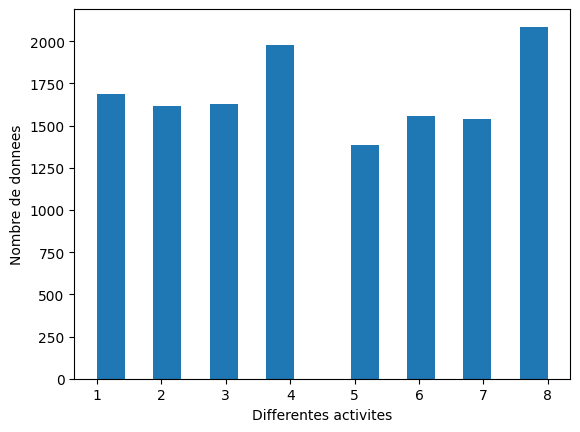

In [10]:
# Data loading

# Sensors part (Accelerometer, Gyroscope and Magnetometer) placed on the Hand 
# (do the same for the 2 other sensor positions: torso and ankle)
fh1=np.load('DataHandAcc.npz')
DataHandAcc=fh1['DataHandAcc']
fh2=np.load('DataHandGyro.npz')
DataHandGyro=fh2['DataHandGyro']
fh3=np.load('DataHandMagneto.npz')
DataHandMagneto=fh3['DataHandMagneto']
# TODO

# Ankle
fh4=np.load('DataAnkleAcc.npz')
DataAnkleAcc=fh4['DataAnkleAcc']
fh5=np.load('DataAnkleGyro.npz')
DataAnkleGyro=fh5['DataAnkleGyro']
fh6=np.load('DataAnkleMagneto.npz')
DataAnkleMagneto=fh6['DataAnkleMagneto']

#Chest
fh7=np.load('DataChestAcc.npz')
DataChestAcc=fh7['DataChestAcc']
fh8=np.load('DataChestGyro.npz')
DataChestGyro=fh8['DataChestGyro']
fh9=np.load('DataChestMagneto.npz')
DataChestMagneto=fh9['DataChestMagneto']


# Loading the ground truth: labels
fl=np.load('labels.npz')
labels=fl['labels']

# Repartition of data by class
plt.hist(labels,bins=16)
plt.xlabel('Differentes activites')
plt.ylabel('Nombre de donnees')
plt.show()

In [12]:
# Separation of data into training and test databases
from sklearn.model_selection import train_test_split

listeData=[*range(labels.shape[0])]
listeData=np.random.randint(len(listeData), size = 500) # Smaller dataset
labels=labels[listeData] # Fit labels to the new listeData
Liste_Base_train, Liste_Base_test, y_train, y_test = train_test_split(listeData, labels, test_size=0.20, random_state=42)

# Part I-a: Implementing the dynamic programming algorithm 

1. Write a function in DTW python that implements the calculation. Implement it such that
- the local distance used is a parameter which is a callable function with 2 inputs and 1 output: e.g. euclidian distance(a, b)
- local distances can be computed with any type of input local data: e.g. (a,b)=('A','T'), (a,b)=(12,22), (a,b)=( (1,2,3), (4,5,6) ).

In [13]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((np.array(a) - np.array(b))**2))


def dtw(ts_a, ts_b, distance_func=euclidean_distance):
    m = len(ts_a)
    n = len(ts_b)

    # Matrix to store the accumulated distances
    matrix = np.zeros((m + 1, n + 1))

    # Initialize the first row and column to infinity to ensure movement to the right or down
    matrix[:, 0] = np.inf
    matrix[0, :] = np.inf

    # Start point
    matrix[0, 0] = 0

    # Accumulated distances
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = distance_func(ts_a[i - 1], ts_b[j - 1])
            matrix[i, j] = cost + min(matrix[i - 1, j],      # Insertion
                                       matrix[i, j - 1],      # Deletion
                                       matrix[i - 1, j - 1])  # Match

    return matrix[-1, -1]


2. Test your methods on the examples given in class.

In [15]:
# Time series s1 and s2
#X = [1, 3, 9, 2, 1]
#Y = [2, 0, 0, 8, 7, 2]
#X = [7, 1, 2, 5, 9]
#Y = [1, 8, 0, 4, 4, 2, 0]
X = [3, 1, 2, 2, 1]
Y = [2, 0, 0, 3, 3, 1, 0]

# Calculate the alignment score
matrix = dtw(X, Y, euclidean_distance)
print('DTW distance DTW(X, Y) =', matrix)


DTW distance DTW(X, Y) = 6.0


We tried calculating the matrix by hand and we can confirm that it's the right distance. 

# Part I-b: DTW human activity recognition system

For each test time profile :

a) For each class, compute the DTW score between the test temporal profile and the temporal profiles of the class. Test with data from only one sensor then include them all if possible.

b) Determine the class membership by k-nearest neighbors

**Information:**
We use the library sklearn.neighbors to execute an example of this classification algorithm.

The algorithm k-NN is implemented in a package called **neighbors**.
Here are the main commands:
- The line **clf = neighbors.KNeighborsClassifier(n_neighbors)** creates an object of type classifier based on the n_neighbors closest neighbors,
- The instruction clf.fit(X, y) uses the data to define the classifier (training),
- The command **clf.predict()** is used to classify the new examples,
- The command **clf.predict_proba()** allows to estimate the probability of the proposed classification,
- The command **clf.score(xtest, ytest)** computes the global score of the classifier for a given dataset.

<img src="https://miro.medium.com/v2/resize:fit:488/1*9h-WczF6csbeut5vsvjSUA.gif" alt="k-NN example" />

KNeighborsClassifier takes as argument *metrics* which can be:
- a string with the distance name: default='minkowski'
- a callable function taking as input 2 arrays representing 1D vectors and returning one value indicating the distance between those vectors. **Use this option with the DTW function you implemented.**

a)

In [16]:

# Function to compute DTW scores for each class
def compute_dtw_scores(test_profile, class_profiles, distance_func=dtw):
    dtw_scores = []
    for class_profile in class_profiles:
        dtw_score = distance_func(test_profile, class_profile)
        dtw_scores.append(dtw_score)
    return dtw_scores

# Function to smooth the signal using downsampling
def smooth_signal(X, k):
    for i in range(len(X)):
        Xi = X[i]
        downsample = math.ceil(len(Xi) / k)
        for j in range(downsample):
            Xj = Xi[j * k : min((j + 1) * k, len(Xi)), :]
            X[i, j] = np.mean(Xj, axis=0)
    X = X[:, :downsample, :]
    return X

# Choose a downsampling factor (k) based on your requirement
k = 5

# Example usage for one sensor (e.g., accelerometer on hand)
sensor_data_train = DataHandAcc[Liste_Base_train]
sensor_data_test = DataHandAcc[Liste_Base_test]

# Apply smoothing to training and test data
smoothed_sensor_data_train = smooth_signal(sensor_data_train, k)
smoothed_sensor_data_test = smooth_signal(sensor_data_test, k)

# Choose a test sample index (you can iterate over all test samples)
test_index = 0
test_sample = smoothed_sensor_data_test[test_index]

# Iterate over classes
for class_label in np.unique(labels):
    class_indices = np.where(y_train == class_label)[0]
    class_samples = smoothed_sensor_data_train[class_indices]

    # Compute DTW scores for the current class
    dtw_scores = compute_dtw_scores(test_sample, class_samples, distance_func=dtw)

    # Print the DTW scores for the current class
    print(f"DTW scores for class {class_label}: {dtw_scores}")


DTW scores for class 1: [9.126112397760153, 16.32490222528577, 10.44389350246638, 8.073181124404073, 9.126112397760153, 21.58454546984285, 597.1680235862732, 771.9993464946747, 9.126112397760153, 771.9993464946747, 9.860301892273128, 316.82291743159294, 771.9993464946747, 10.44389350246638, 597.1680235862732, 16.32490222528577, 8.073181124404073, 16.32490222528577, 771.9993464946747, 9.126112397760153, 9.126112397760153, 16.32490222528577, 9.860301892273128, 21.58454546984285, 9.126112397760153, 21.58454546984285, 9.860301892273128, 771.9993464946747, 10.44389350246638, 771.9993464946747, 16.32490222528577, 597.1680235862732, 21.58454546984285, 10.44389350246638, 10.44389350246638, 16.32490222528577, 597.1680235862732]
DTW scores for class 2: [877.5347990989685, 8.29615604924038, 201.6840108036995, 597.388605594635, 8.29615604924038, 201.6840108036995, 597.388605594635, 9.079080924391747, 597.388605594635, 8.29615604924038, 8.29615604924038, 9.079080924391747, 596.9759883880615, 597.38

b)

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# Reshape the data to use it with k-NN classifier
X_train_reshaped = smoothed_sensor_data_train.reshape(smoothed_sensor_data_train.shape[0], -1)
X_test_reshaped = smoothed_sensor_data_test.reshape(smoothed_sensor_data_test.shape[0], -1)

# Choose the number of neighbors for k-NN
n_neighbors = 3  # You can adjust this parameter

# Initialize k-NN classifier with DTW distance metric
knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric=dtw)

# Train the classifier
knn_classifier.fit(X_train_reshaped, y_train)

# Function to predict class for a given test sample index
def predict_class(test_index):
    predicted_class = knn_classifier.predict(X_test_reshaped[test_index].reshape(1, -1))
    return predicted_class[0]

# Example usage for predicting class of the first test sample
predicted_class = predict_class(0)
print(f"Predicted class for test sample 0: {predicted_class}")


Predicted class for test sample 0: 3


In [18]:
from sklearn.neighbors import KNeighborsClassifier

# Reshape the data to use it with k-NN classifier
X_train_reshaped = smoothed_sensor_data_train.reshape(smoothed_sensor_data_train.shape[0], -1)
X_test_reshaped = smoothed_sensor_data_test.reshape(smoothed_sensor_data_test.shape[0], -1)

# Choose the number of neighbors for k-NN
n_neighbors = 3  # You can adjust this parameter

# Initialize k-NN classifier with DTW distance metric
knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric=dtw)

# Train the classifier
knn_classifier.fit(X_train_reshaped, y_train)

# Function to predict class for a given test sample index
def predict_class(test_index):
    predicted_class = knn_classifier.predict(X_test_reshaped[test_index].reshape(1, -1))
    return predicted_class[0]

# Example usage for predicting class of the first test sample
predicted_class = predict_class(1)
print(f"Predicted class for test sample 1: {predicted_class}")


Predicted class for test sample 1: 3


In [20]:
#from sklearn.neighbors import KNeighborsClassifier

# Reshape the data to use it with k-NN classifier
#X_train_reshaped = smoothed_sensor_data_train.reshape(smoothed_sensor_data_train.shape[0], -1)
#X_test_reshaped = smoothed_sensor_data_test.reshape(smoothed_sensor_data_test.shape[0], -1)

# Choose the number of neighbors for k-NN
#n_neighbors = 3  # You can adjust this parameter

# Initialize k-NN classifier with DTW distance metric
#knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric=dtw)

# Train the classifier
#knn_classifier.fit(X_train_reshaped, y_train)

# Function to predict class for a given test sample index
#def predict_class(test_index):
    #predicted_class = knn_classifier.predict(X_test_reshaped[test_index].reshape(1, -1))
    #return predicted_class[0]

# Example usage for predicting class of the first test sample
#predicted_class = predict_class(2)
#print(f"Predicted class for test sample 2: {predicted_class}")

## **Evaluation:** 
From the prediction on the test set obtained after DTW, compute the confusion matrix that counts the number of well-ranked and poorly-ranked data.

Analyse the results (accuracy, execution time, ...)

In [45]:
# TODO

# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('Matrice de confusion par DTW')

# Score de performance
print('Score de classification')
#print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

Matrice de confusion par DTW
Score de classification


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import time

# Function to predict class for all test samples
def predict_all_classes(X_test_reshaped):
    return knn_classifier.predict(X_test_reshaped)

# Reshape the data to use it with k-NN classifier
X_train_reshaped = smoothed_sensor_data_train.reshape(smoothed_sensor_data_train.shape[0], -1)
X_test_reshaped = smoothed_sensor_data_test.reshape(smoothed_sensor_data_test.shape[0], -1)

# Record the start time for execution time analysis
start_time = time.time()

# Predict classes for all test samples
predicted_classes = predict_all_classes(X_test_reshaped)

# Calculate execution time
execution_time = time.time() - start_time
print(f"Execution time for k-NN prediction: {execution_time} seconds")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy on the test set: {accuracy}")


***Conclusion***

In this project, we aimed to predict human activities using different sensors like accelerometers and gyroscopes. We implemented a recognition system using Dynamic Time Warping (DTW) and a k-NN classifier. 
However, we weren't able to evaluate our model by doing the confusion matrix since the program was taking too long to run (even though we reduced the dataset). 


# Part II: Comparison of dynamic programming with a neural network classification method after PCA dimension reduction

In this section, we will compare the results of DTW with those of a data classification method: neural networks (Multi-Layer Perceptron).

We'll be using the functions for calculating PCA and MLPClassifier via the *scikit-learn* python library.

In [2]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

### PCA pre-processing


To test another classification method, 


1. From the Data_App data in the training database, and using the *PCA* function in the *scikit-learn* library, calculate the $p$ principal axes of the PCA by
extracting the $p$ eigenvectors, denoted $X_1$, $X_2$,..., $X_p$, associated with the $p$ largest eigenvalues of the variance-covariance matrix
variance-covariance matrix $\Sigma_{App}$. These eigenvectors will form the new database.


2. Project the data from the training and test database into this new database by multiplying each vector
vector by the base $P = [X_1X_2...X_p]$.


*Note:* you can also implement PCA by extracting the
extracting the $p$ eigenvectors, denoted $X_1$, $X_2$,... $X_p$, associated with the $p$ largest eigenvalues of the
variance-covariance matrix $\Sigma_{App}$ (by the functions *np.cov* and *np.linalg.eig*). These eigenvectors will form the new frame P. Then project the data from the training and test frames into this new frame by multiplying each vector by the frame $P = [X_1X_2..X_p]$.

In [ ]:
# TODO

### Classification using neural networks
1. Classification using neural networks
2. Evaluate results using confusion matrix, loss function, etc.
3. Test different architectures and solvers: train on the training set and compute score on the test set

Analyse the results (accuracy, execution time, ...)

We will use the library **sklearn.model_selection** to develop ANN of type Multi Layer Perceptron (MLP). We use the class: MLPClassifier.

<img src="https://rasbt.github.io/mlxtend/user_guide/classifier/NeuralNetMLP_files/neuralnet_mlp_1.png" alt="MLP example" />

This model optimizes the cross entropy function (loss function) and a gradient based method.
The main parameters of this class are:
- **hidden_layer_sizes** is a tuple that specifies the number of neurons in each hidden layer; from the entrance to the exit. For example, a unique hidden layer of 55 neurons, hidden_layer_sizes = (55); for three hidden layers of size respectively 50, 12 and 100 neurons, hidden_layer_sizes = (50, 12, 100).
- **activation** defines the activation function for hidden layers: {"identity", "logistic", "tanh", "relu"}, default "relu"
    - ‘identity’, no-op activation, linear bottleneck, returns f(x) = x
    - ‘logistic’, logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
    - ‘tanh’, hyperbolic tan function, returns f(x) = tanh(x).
    - ‘relu’, rectified linear unit function, returns f(x) = max(0, x)
- **solver** {"lbfgs", "sgd", "adam"} specifies the algorithm used to minimize the output loss function. "Adam" is implemented by default for large databases. For small databases, ‘lbfgs’ may converge better.
- **alpha** default value=0.0001: is the magnitude of the L2 regularization. It is a method of regulation (to prevent overfitting) whose purpose is to penalize heavy weights. We add the penalty to the cost function.
- **max iter**, default =200, indicates the max number of iterations of the solver.
- **tol** , default 1e-4: is a tolerance factor that allows the solver to be stopped early when there is no improvement.
- **Verbose** bool, default=’False’ : change to “True” to print progress messages to stdout.
- **warm_start** bool, default=’False’: When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution.
- **early_stopping** bool, default=’False’: Whether to use early stopping to terminate training when validation score is not improving (prevent overfitting). If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. If early stopping is False, then the training stops when the training loss does not improve by more than tol for n_iter_no_change consecutive passes over the training set. Only effective when solver=’sgd’ or ‘adam’.
- **validation_fraction** float, default=0.1 The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True.
- **n_iter_no_change** int, default=10: Maximum number of epochs to not meet tol improvement. Only effective when solver=’sgd’ or ‘adam’.

The main commands are:
- mlp = MLPClassifier(hidden_layer_sizes=(20, 20, 10,), max_iter=300, activation='relu', solver='adam', random_state=42)
- mlp.fit(xtrain, ytrain)
- ypred = mlp.predict(xtest)

Accuracy of the model can eventually be computed using the library **sklearn.metrics** and the commands:
- Score: accuracy_score(y_test, y_pred)
- Report: classification_report(y_test, y_pred))

The usual sklearn learning and testing functions are as follows: (**fit**, **predict**, **score**).

In [5]:
from sklearn.neural_network import MLPClassifier

In [ ]:
# TODO

# Partie III (Bonus): reduction of the training basis by k-medoids to optimize classification by k-NN with DTW as similarity measure

For each class of activity
a) Compute medoids using *k-medoids* from the scikit-learn library with DTW as similarity measure.

b) Vary the parameter k and observe the evolution of the *silhouette score*: select the best by the elbow method

c) Replace the samples with the medoids found from the best k parameter

Finally, run the k-NN algorithm for classification and evaluate as before: the only change is that your training set has been replaced

**Information:**
We use the KMedoids (kM) method: this is an unsupervised approach which clusters your data in k groups such that a similarity measure is:
- minimized inside each group
- maximized inside between groups
We obtain for each group a centroid (or medoid) which is at the center and thus represents best the group (w.r.t. the similarity measure).

The algorithm kM is implemented in a package called **sklearn_extra.cluster**.
Here are the main commands:
- The line **clf = sklearn_extra.cluster.KMedoids(n_clusters=k)** creates an object of type classifier based on the n_neighbors closest neighbors,
- The instruction clf.fit(X, y) uses the data to define the classifier (training),
- The command **clf.predict()** is used to classify the new examples,
- The command **clf.predict_proba()** allows to estimate the probability of the proposed classification,
- The command **clf.score(xtest, ytest)** computes the global score of the classifier for a given dataset.

<img src="https://scikit-learn-extra.readthedocs.io/en/stable/_images/sphx_glr_plot_kmedoids_digits_001.png" alt="k-Medoids example" />

KMedoids takes as argument *metrics* which can be your DTW function.

The silhouette score is then a measure of the quality of your clustering, and is implemented as the function silhouette_score in a package called **sklearn.metrics**.

In [ ]:
# TODO (Bonus)